<a href="https://colab.research.google.com/github/chlee9401/Lee_Chang_Hoon/blob/master/Transfer_Learning_InceptionV3_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
class TransferLearning :
    def __init__(self) : #Transfer Learning Class Constructor
        #Data Initialization
        self.trainImage = None
        self.trainLabel = None
        self.validationImage = None
        self.validationLabel = None
        self.testImage = None
        self.testLabel = None
        self.dataGen = None
        #Model Initialization
        self.baseModel = None
        self.model = None
        #Seed Initialization
        self.seed = np.random.seed(1)
        #Weight Decay Initialization for Regularization
        self.weightDecay = 0.0005
        #Learning Rate Initialization
        self.learningRate = 0.0005
        self.learningRateDecay = 1e-6
        self.learningRateDrop = 20
        #Batch Size Initialization
        self.batchSize = 64
        #Epoch Initialization
        self.initEpoch = 10
        self.fineTuneEpoch = 20
        #Input Image Dimension
        self.imageSize = Input(shape = (32, 32, 3))

    def loadDataset(self) : #Load Cifar100 Dataset
        (self.trainImage, self.trainLabel), (self.testImage, self.testLabel) = cifar100.load_data(label_mode='fine')

    def dataPreProcess(self) : #Pre-Processing Dataset 
        #Image Pixel Normalization
        self.trainImage, self.testImage = self.trainImage.astype("float32"), self.testImage.astype("float32")
        self.trainImage = self.trainImage / 255
        self.testImage = self.testImage / 255
        #Data Split
        self.trainImage, self.validationImage, self.trainLabel, self.validationLabel = train_test_split(self.trainImage, self.trainLabel, test_size = 0.2, random_state = self.seed)
        #One-Hot Encoding
        self.trainLabel = to_categorical(self.trainLabel)
        self.validationLabel = to_categorical(self.validationLabel)
        self.testLabel = to_categorical(self.testLabel)

    def dataAugmentation(self) : #Data Augmentation
        self.dataGen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=False, preprocessing_function = preprocess_input)  
        self.dataGen.fit(self.trainImage, seed = self.seed)

    def summarizeDiagnostics(self, history) : #Graph Implementation
        plt.subplot(121)
        plt.title('Cross Entropy Loss')
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='test')
        plt.legend("upper right")
        plt.subplot(122)
        plt.title('Classification Accuracy')
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='test')
        plt.legend("upper right")
        filename = sys.argv[0].split('/')[-1]
        plt.savefig("/content/drive/MyDrive/cifar100_Transfer_Learning_Benchmarking.png")
        plt.close()

    def defineBaseModel(self) : #Define Base Model for Training
        self.baseModel = InceptionV3(include_top = False, weights = "imagenet", input_shape = (224, 224, 3), pooling = "avg")

    def fineTune(self) : #Fine Tune Base Model Layers
        for layer in self.baseModel.layers[:241] :
                layer.trainable = False

        for layer in self.baseModel.layers :
            if isinstance(layer, BatchNormalization) : #Only Re-Train Batch Normalization Layer
                layer.trainable = True

    def createModel(self) : #Build Model
        self.model = UpSampling2D(size = (7, 7))(self.imageSize)

        self.model = self.baseModel(self.model)

        output = Dense(100, activation = "softmax")(self.model)

        self.model = Model(self.imageSize, output)

    def learningRateScheduler(self, epoch) : #Learning Rate Decay
        return self.learningRate * (0.5 ** (epoch // self.learningRateDrop))

    def compileModel(self) : #Convolutional Neural Network Compilation        
        opt = Adam(lr = self.learningRate, decay = self.learningRateDecay)
        self.model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy", "top_k_categorical_accuracy"])
        self.baseModel.summary()
        self.model.summary()
        
    def runTraining(self) : #Run Tranining
        self.loadDataset()
        self.dataPreProcess()
        """
        self.dataAugmentation()
        """
        self.defineBaseModel()
        self.fineTune()
        self.createModel()
        self.compileModel()
        modelCheck = ModelCheckpoint("cifar100_Transfer_Learning_Benchmarking.h5", monitor = "val_acc", mode = "max", verbose = 1, save_best_only = True)
        history = self.model.fit(self.trainImage, self.trainLabel, batch_size = self.batchSize, epochs = self.initEpoch + self.fineTuneEpoch, initial_epoch = self.initEpoch, verbose = 1, callbacks=[modelCheck, LearningRateScheduler(self.learningRateScheduler)], validation_data = (self.validationImage, self.validationLabel), steps_per_epoch = int(self.trainImage.shape[0] / self.batchSize))
        self.summarizeDiagnostics(history)
        self.model.save("cifar100_Transfer_Learning_Benchmarking_Final.h5")

87916544/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

FileNotFoundError: ignored

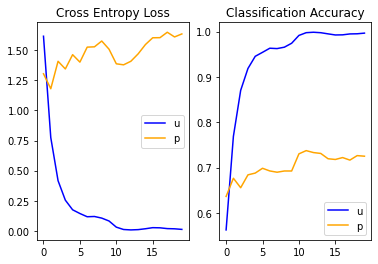

In [ ]:
if __name__ == "__main__" :
    TransferLearning().runTraining()